# Change Formula Type Prediction

# 1. Situation
Given a data with four features customer_id, retention_days, formula_changes, current_formula_type.

# 2. Task
Make an additional feature as the label(Y) and the Y is that we transform the number formula changes into whether the customer change their formula last year.

# 3. Action

<ul>
<li>[Part 1: Data Exploration](#Part-1:-Data-Exploration)
<li>[Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
<li>[Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
<li>[Part 4: Feature Selection](#Part-4:-Feature-Selection)
</ul>

## Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve
from sklearn import metrics

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
os.chdir("/Users/yc/Desktop")
df = pd.read_csv('Curology_case_study.csv')

In [2]:
df.head()

,customer_id,retention_days,formula_changes,current_formula_type
0,57602,88,2,Anti-Aging
1,44257,81,2,Balancing
2,63100,15,3,Balancing
3,71250,123,2,Balancing
4,53005,52,2,Acne


In [3]:
print ("Num of rows: " + str(df.shape[0])) # row count
print ("Num of columns: " + str(df.shape[1])) # col count

Num of rows: 50
Num of columns: 4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
customer_id             50 non-null int64
retention_days          50 non-null int64
formula_changes         50 non-null int64
current_formula_type    50 non-null object
dtypes: int64(3), object(1)
memory usage: 1.6+ KB


### Part 1.2: Data cleaning

In [5]:
# None

### Part 1.3:  Understand the features

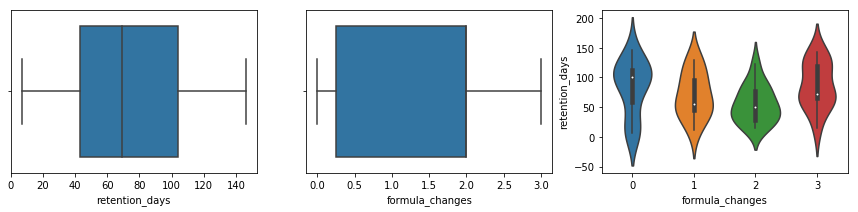

In [6]:
fig, ax = plt.subplots(1,3, figsize=(15, 3))
sns.boxplot(df["retention_days"], ax = ax[0])
sns.boxplot(df["formula_changes"], ax = ax[1])
sns.violinplot(x = df["formula_changes"], y = df["retention_days"], ax = ax[2])
plt.show()

In [7]:
df["current_formula_type"].value_counts()

Acne          20
Balancing     17
Anti-Aging    13
Name: current_formula_type, dtype: int64

# Part 2: Feature Preprocessing

In [8]:
# y is not imbalanced data, not need to do further process
df["label"] = np.where(df['formula_changes'] == 0, 0, 1)  # 0 : No, 1 : Yes
y = df["label"]

# y is made of the number of formula_changes so I don't use it twice.
X = df[["retention_days", "formula_changes"]]

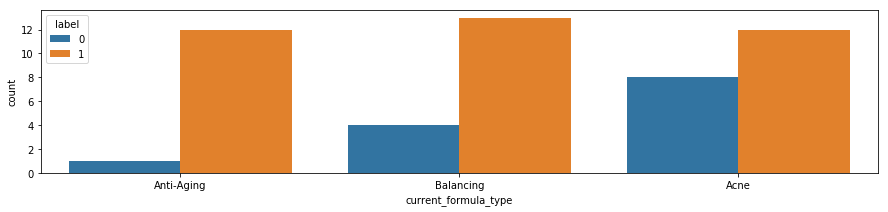

In [9]:
fig, ax = plt.subplots(figsize=(15, 3))
sns.countplot(x = "current_formula_type", hue = "label", data = df)
plt.show()

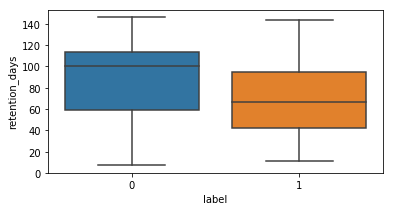

In [10]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(x = df["label"] , y = df["retention_days"])
plt.show()

# Part 3: Model Training and Result Evaluation

### Part 3.1: Split dataset

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3)
print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 35 observation with 2 features
test data has 15 observation with 2 features


In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))

Feature space holds 50 observations and 2 features
Unique target labels: [0 1]


### Part 3.2 + 3.3 : Model Training and Selection + Hyperparameters Tuning

In [13]:
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

#### Part 3.3.1: Find Optimal Hyperparameters - LogisticRegression

In [14]:
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ('l1', 'l2'), 'C': (1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
print_grid_search_metrics(Grid_LR)

Best score: 1.000
Best parameters set:
	C: 1
	penalty: 'l1'


In [16]:
best_LR_model = Grid_LR.best_estimator_

#### Part 3.3.2: Find Optimal Hyperparameters: KNN

In [17]:
parameters = {
    'n_neighbors':[3,5,7,10],
    'weights':["uniform", "distance"],
    'p' : [1, 2]
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [3, 5, 7, 10], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
print_grid_search_metrics(Grid_KNN)

Best score: 1.000
Best parameters set:
	n_neighbors: 7
	p: 1
	weights: 'distance'


In [19]:
best_KNN_model = Grid_KNN.best_estimator_

#### Part 3.3.3: Find Optimal Hyperparameters: Random Forest

In [20]:
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [21]:
parameters = {
    'n_estimators' : [40,60,80],
    "criterion": ["gini", "entropy"],
    "max_depth" : [2,3,4]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [40, 60, 80], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
print_grid_search_metrics(Grid_RF)

Best score: 1.000
Best parameters set:
	criterion: 'gini'
	max_depth: 2
	n_estimators: 60


In [23]:
best_RF_model = Grid_RF.best_estimator_

#### Part 3.3.5: Find Optimal Hyperparameters: SVM

In [24]:
parameters = {
    "C" : [0.05, 1, 50],
    "kernel" : ["linear", "rbf"]
}
Grid_SVM = GridSearchCV(SVC(gamma = "auto", probability = True), parameters, cv=5)
Grid_SVM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.05, 1, 50], 'kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
print_grid_search_metrics(Grid_SVM)

Best score: 1.000
Best parameters set:
	C: 1
	kernel: 'linear'


In [26]:
best_SVM_model = Grid_SVM.best_estimator_

### Part 3.4: Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)

In [27]:
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

def draw_confusion_matrices(confusion_matricies):
    class_names = ["Not","Churn"]
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation = "nearest", cmap = plt.get_cmap("Reds"))
        plt.title("Confusion matrix for %s" % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([""] + class_names)
        ax.set_yticklabels([""] + class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

Logistic Regression
Accuracy is: 1.000
precision is: 1.000
recall is: 1.000


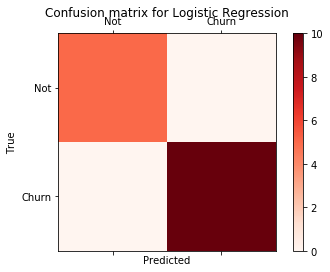

K-Nearest Neighbors
Accuracy is: 1.000
precision is: 1.000
recall is: 1.000


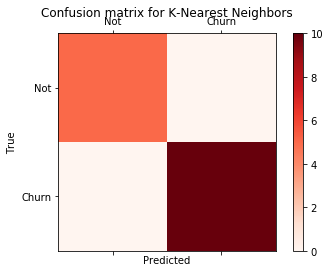

Random Forest
Accuracy is: 1.000
precision is: 1.000
recall is: 1.000


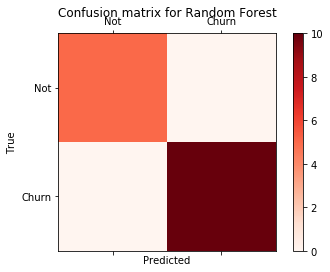

Support Vector Machine
Accuracy is: 1.000
precision is: 1.000
recall is: 1.000


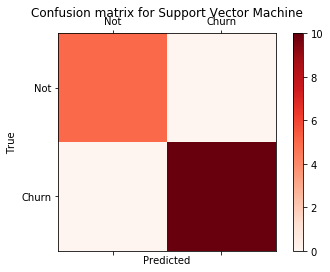

In [28]:
%matplotlib inline

confusion_matrices = [
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
    ("K-Nearest Neighbors", confusion_matrix(y_test,best_KNN_model.predict(X_test))),
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),  
#     ("XGBoost", confusion_matrix(y_test,best_XGBoost_model.predict(dtest))),
    ("Support Vector Machine", confusion_matrix(y_test,best_SVM_model.predict(X_test)))
]

draw_confusion_matrices(confusion_matrices)

### Part 3.4: Model Evaluation - ROC & AUC

RandomForestClassifier, KNeighborsClassifier and LogisticRegression have predict_prob() function 

#### Part 3.4.1: ROC Curve and AUC

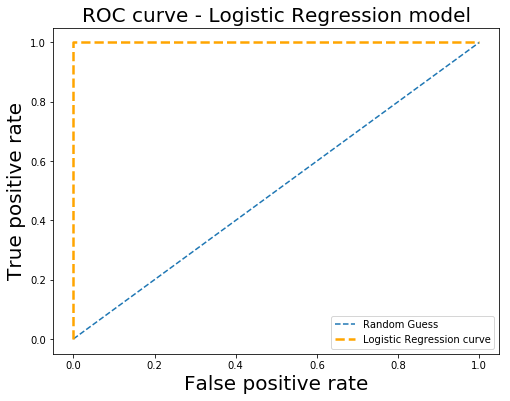

AUC: 1.0 




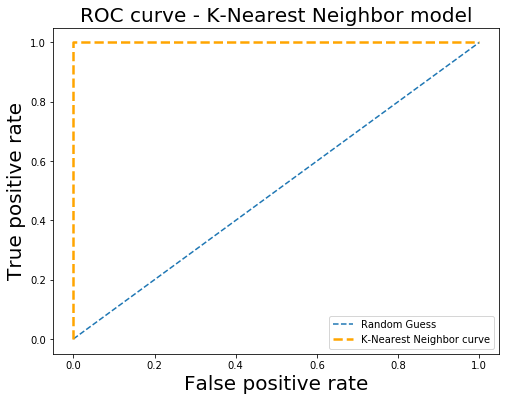

AUC: 1.0 




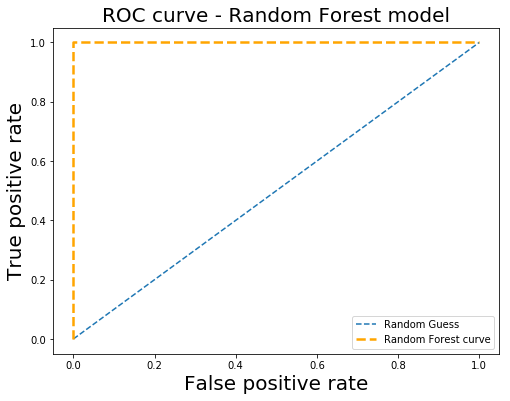

AUC: 1.0 




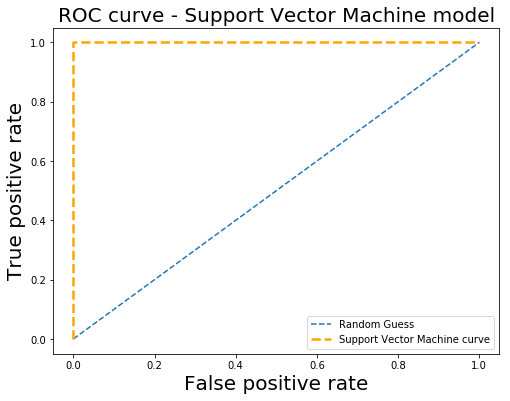

AUC: 1.0 




In [29]:
best_model_ls = [best_LR_model, best_KNN_model, best_RF_model, best_SVM_model]
model_name_ls = ["Logistic Regression", "K-Nearest Neighbor", "Random Forest", "Support Vector Machine"]

def draw_ROC(best_model_ls, model_name_ls):
    for model, name in zip(best_model_ls, model_name_ls):
        y_pred = model.predict_proba(X_test)[:, 1]
        fpos_rate, tpos_rate, _ = roc_curve(y_test, y_pred)

        # plot
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot([0, 1], [0, 1], "--")
        ax.plot(fpos_rate, tpos_rate, lw = 2.5, c = "orange", linestyle = "dashed")
        ax.legend(["Random Guess", "{} curve".format(name)], loc = "best")
        ax.set_xlabel("False positive rate", fontsize = 20)
        ax.set_ylabel("True positive rate", fontsize = 20)
        ax.set_title("ROC curve - {} model".format(name), fontsize = 20)
        plt.show()
        print("AUC: {} \n\n".format(metrics.auc(fpos_rate,tpos_rate)))
        
draw_ROC(best_model_ls, model_name_ls)    

# Part 4: Feature Selection

### Part 4.1:  Logistic Regression Model - Feature Selection Discussion 

The corelated features that we are interested in: (total_day_minutes, total_day_charge), (total_eve_minutes, total_eve_charge), (total_intl_minutes, total_intl_charge).

formula_changes: 2.8654
retention_days: 0.0


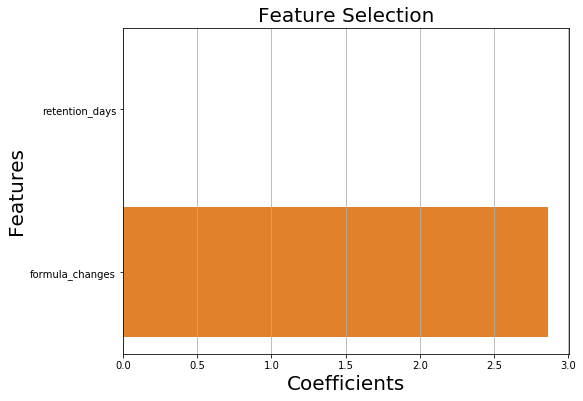

In [30]:
for k,v in sorted(zip(map(lambda x: round(x, 4), best_LR_model.coef_[0]), \
                      X.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))
    
# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid()
sns.barplot([abs(i) for i in best_LR_model.coef_[0]], X.columns)
ax.set_xlabel("Coefficients", fontsize = 20)
ax.set_ylabel("Features", fontsize = 20)
ax.set_title("Feature Selection", fontsize = 20)
plt.show()

### Part 4.2:  Random Forest Model - Feature Importance Discussion

Feature importance ranking by Random Forest Model:
formula_changes: 0.7108
retention_days: 0.2892


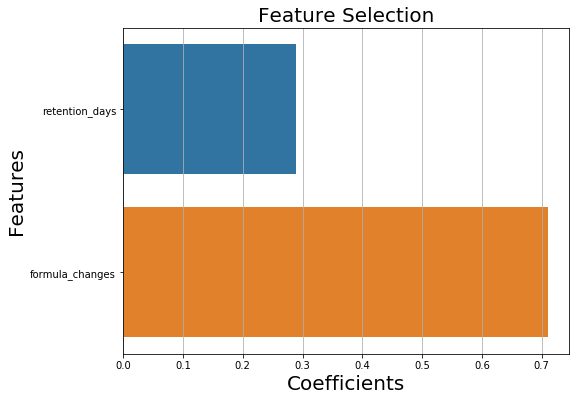

In [31]:
importances = best_RF_model.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), X.columns), reverse=True):
    print (v + ": " + str(k))
    
# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid()
sns.barplot(importances, X.columns)
ax.set_xlabel("Coefficients", fontsize = 20)
ax.set_ylabel("Features", fontsize = 20)
ax.set_title("Feature Selection", fontsize = 20)
plt.show()

# Result

The result is 100% accuracy. There is a high chance that we can only use these two features to predict the outcome. However, due to the number of data is small, which cause a potentially more significant variance and it needs more data to prove the performance.

Here I will choose random forest as the optimal model even logistic regression and support vector machine also gives a performace. Among the three models with 100% accuracy, logistic regression is using L1 regularization so that the coefficient of the retention day tend to be 0. While we already know that retention day has some relationship to the label(Y), skip logistic regression will be a better way. Also, the support vector machine will be slow when dealing with large number of data. So, consider future tasks, the random forest classifier is the best model so far.